# Purpose: Previously I had used a streak generation method which was just a 1D Gaussian duplicated multiple times across an axis, which was not an accurate method for creating streaks. In this notebook I use the better method of using a 2D Gaussian.

In [1]:
import numpy as np
import scipy.special
import math
import matplotlib.pyplot as plt
import glob
import os
from astropy.visualization import LinearStretch, ZScaleInterval, ImageNormalize
from astropy.io import fits
import sep
from scipy import stats
import random
params_gamma_width = [4.79235037, 11.40523025, 1.64361626]
params_gamma_amplitude = [1.09717868, 1.99999993, 3.7169828]
params_gamma_length = [4.16396709, 8.0180058, 2.68969172]


In [162]:
def generate_streak(x_size, y_size, x_center, y_center, angle, amplitude, length, width, psf_width):
    x = np.arange(0, x_size)
    y = np.expand_dims(np.arange(0, y_size), -1)
    
    hx = (x - x_center) * math.cos(angle) - (y - y_center) * math.sin(angle)
    hy = (x - x_center) * math.sin(angle) + (y - y_center) * math.cos(angle)
    
    arr = np.exp(-hy**2/(2 * psf_width**2)) * (scipy.special.erf((hx + length/2) / (psf_width * np.sqrt(2))) - scipy.special.erf((hx - length/2) / (psf_width * np.sqrt(2))))
    arr *= amplitude / np.max(arr)
    
#     covariance = psf_width
#     arr = amplitude / 2 * (scipy.special.erf((length - 2 * hx) / (2 * np.sqrt(2 * covariance))) + scipy.special.erf((length + 2 * hx) / (2 * np.sqrt(2 * covariance)))) * np.exp(-0.5 * (hy**2) / (covariance + width**2)) * np.sqrt(width ** 2 / (width ** 2 + covariance))

    return arr, arr > amplitude / 200


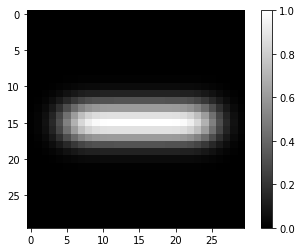

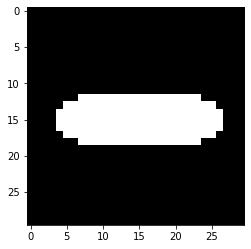

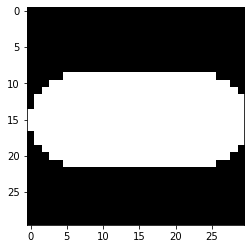

In [161]:
plt.imshow(generate_streak(30, 30, 15, 15, 0, 1, 20, 1, 2)[0], cmap="gray")
plt.colorbar()
plt.figure()
plt.imshow(generate_streak(30, 30, 15, 15, 0, 1, 20, 1, 2)[0] > 1 / 4, cmap="gray")
plt.figure()
plt.imshow(generate_streak(30, 30, 15, 15, 0, 1, 20, 1, 2)[0] > 1/200, cmap="gray")

In [7]:
def convert_sci_to_ref(file):
    info = file.split("/")[-1].split("_")[1:-1]
    return "/mnt/etdisk9/ztf_neos/training_examples/reference/ztf_" + "_".join(info[1:4] + info[5:6]) + "_refimg.fits"

filenames = glob.glob("/mnt/etdisk9/ztf_neos/training_examples/science/*.fits")
filename_pairs = [(file, convert_sci_to_ref(file)) for file in filenames]
filename_pairs = [pair for pair in filename_pairs if os.path.isfile(pair[1])]

In [8]:
size = 150
def normalize(arr, samples=size * size // 8):
    arr = np.copy(arr)
    vmin, vmax = ZScaleInterval(samples, contrast=0.3, max_iterations=3).get_limits(arr)
    arr -= vmin
    arr /= vmax - vmin
    arr = np.clip(arr, 0, 1)
    return (arr - np.median(arr)) / np.std(arr)

In [9]:
sci = fits.getdata(np.random.choice(filenames)) 

In [10]:
x = np.random.randint(100, 3000-size)
y = np.random.randint(100, 3000-size)
sci_crop = np.array(sci[y:y+size, x:x+size], dtype=np.float32)

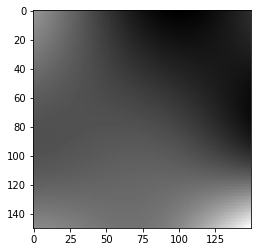

In [11]:
bkg = sep.Background(sci_crop)
plt.imshow(bkg.back(), cmap="gray")

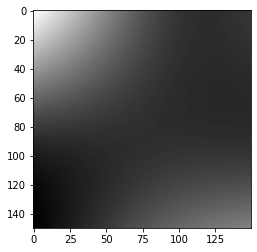

In [12]:
plt.imshow(bkg.rms(), cmap="gray")

In [13]:
print(bkg.rms())

[[5.966546  5.9612145 5.955826  ... 5.4555845 5.456881  5.458199 ]
 [5.9606433 5.955373  5.9500456 ... 5.4555006 5.456782  5.4580846]
 [5.9546947 5.949484  5.9442186 ... 5.4553733 5.45664   5.457927 ]
 ...
 [5.3227186 5.3252907 5.327877  ... 5.6340656 5.6350155 5.6359596]
 [5.3223715 5.32498   5.327601  ... 5.6387243 5.6397047 5.6406794]
 [5.3220434 5.324686  5.327344  ... 5.6433992 5.6444097 5.6454153]]


In [14]:
import subprocess
def swarp_align(sci_file, ref_file, realign=False):
    ref, header = fits.getdata(ref_file, header=True)

    filename_sci = sci_file.split("/")[-1]
    directory = "/media/rd1/ztf_neos/pipeline/resampled/" + filename_sci[:-len(".fits")]

    try:
        os.makedirs(directory, exist_ok=realign)

    except FileExistsError:
        pass

    else:
        with open(directory + "/coadd.head", "w") as f:
            f.write(repr(header) + "\nEND     ")

        subprocess.run(["swarp", sci_file, "-c", "/home/fwang/Pipeline/swarp.conf", "-VERBOSE_TYPE", "QUIET"],
                       cwd=directory, stderr=subprocess.DEVNULL)

    return [fits.getdata(directory + "/coadd.fits"), ref]

In [15]:
min_offset = 10
gain = 6.2
def implant_random_streak(image, return_info=False, predetermined_vals=False, streak=None, mask=None, factor=None):
    
    image = np.copy(image)
    
    while True:
    
        if np.random.random() < 0.8:
            std = stats.gamma.rvs(*params_gamma_width) * 0.05
        else:
            # thick streaks
            std = 1.5 + 2 * np.abs(np.random.randn())

        if np.random.random() < 0.5:
            # based on the collected distribution (not below 10 however)
            length = stats.gamma.rvs(*params_gamma_length)
        elif np.random.random() < 0.8:
            # short streaks
            length = np.random.random() * 3 + 7
        else:
            # long streaks
            length = np.random.random() * 20 + 10
        
        if length > 3 and std > 0.5:
            break
    
    if not predetermined_vals:
    
        x = np.random.randint(min_offset, size - min_offset)
        y = np.random.randint(min_offset, size - min_offset)

        rotation = np.random.random() * np.pi * 2

        streak, mask = generate_streak(size, size, x, y, rotation, 1, length, 1, std)

        if np.random.random() < 0.8:
            factor = 1 + np.abs(np.random.randn()) * 0.5
        else:
            factor = np.random.random() * 2 + 2

    bkg = sep.Background(image)
    amp_min = np.percentile(np.abs(bkg.back()[mask] - image[mask]), 68) * 3
    
    streak_scaled = streak * factor * amp_min
    streak_scaled = np.random.poisson(streak_scaled * gain) / gain
    
    if return_info:
        return image + streak_scaled, (x, y, rotation, length, std, streak, mask, factor, amp_min)
    
    return image + streak_scaled

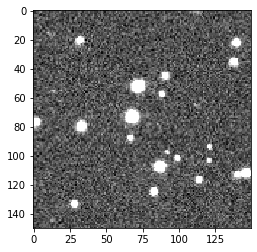

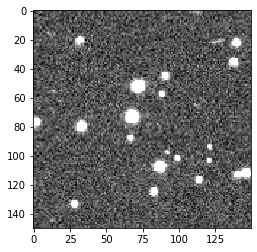

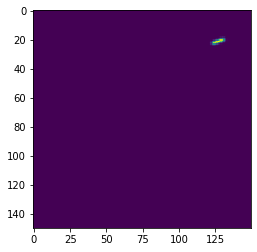

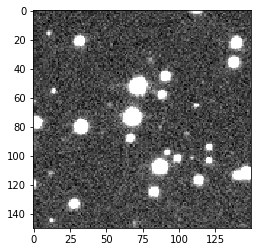

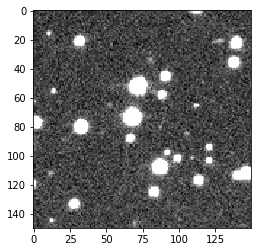

In [121]:
sci, ref = swarp_align(*random.choice(filename_pairs))
x = np.random.randint(100, 3000-size)
y = np.random.randint(100, 3000-size)
sci_crop = np.array(sci[y:y+size, x:x+size], dtype=np.float32)

plt.imshow(normalize(sci_crop), cmap="gray")
plt.figure()

streaked_image, (x_streak, y_streak, rotation, length, std, streak, mask, factor, amp_min) = implant_random_streak(sci_crop, return_info=True)

plt.imshow(normalize(streaked_image), cmap="gray")
plt.figure()

plt.imshow(streak)
plt.figure()

ref_crop = np.array(ref[y:y+size, x:x+size], dtype=np.float32)
streaked_image_ref = implant_random_streak(ref_crop, predetermined_vals=True, streak=streak, mask=mask, factor=factor)

plt.imshow(normalize(ref_crop), cmap="gray")
plt.figure()
plt.imshow(normalize(streaked_image_ref), cmap="gray")

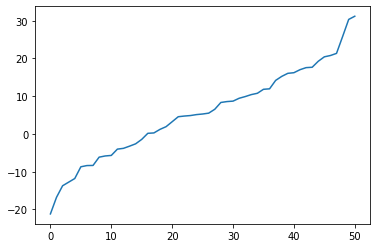

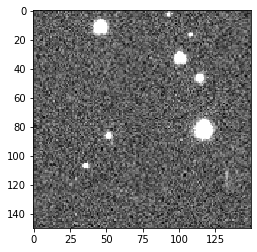

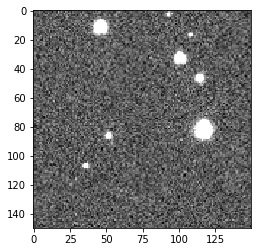

In [1190]:
plt.plot(np.sort(sci_crop[mask])[:])
plt.figure()
plt.imshow(normalize(sci_crop + streak * 20.0), cmap="gray")
plt.figure()
plt.imshow(normalize(sci_crop), cmap="gray")

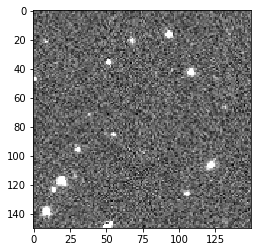

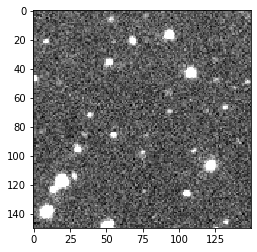

In [996]:
sci, ref = swarp_align(*random.choice(filename_pairs))
x = np.random.randint(100, 3000-size)
y = np.random.randint(100, 3000-size)
sci_crop = np.array(sci[y:y+size, x:x+size], dtype=np.float32)

plt.imshow(normalize(sci_crop), cmap="gray")
plt.figure()
ref_crop = np.array(ref[y:y+size, x:x+size], dtype=np.float32)
plt.imshow(normalize(ref_crop), cmap="gray")

4.8546286 19.418514251708984


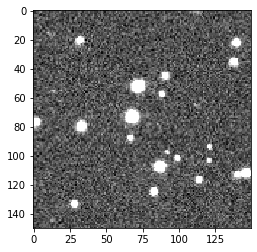

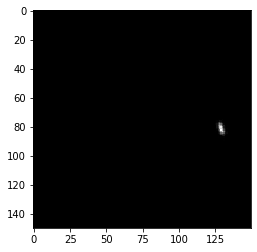

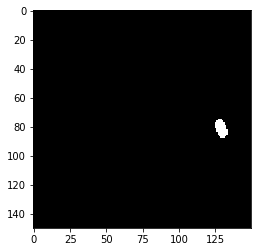

<Figure size 432x288 with 0 Axes>

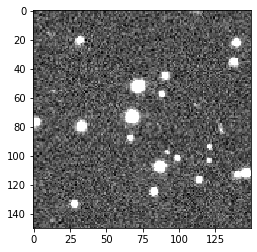

In [266]:
# sci = fits.getdata(np.random.choice(filenames)) 
# x = np.random.randint(100, 3000-size)
# y = np.random.randint(100, 3000-size)
# sci_crop = np.array(sci[y:y+size, x:x+size], dtype=np.float32)

plt.imshow(normalize(sci_crop), cmap="gray")
plt.figure()

# length = np.random.uniform(10, 20)

x = np.random.randint(length//4, size - length//4)
y = np.random.randint(length//4, size - length//4)
std = stats.gamma.rvs(*params_gamma_width) * 0.05
# std = 2
# print(std)
# streak, mask = generate_streak(size, size, x, y, np.random.random() * np.pi * 2, 1, length, 1, std)#0.75 + 0.5 * np.abs(np.random.randn()))
streak, mask = generate_streak(size, size, x, y, np.random.random() * np.pi * 2, 1, 7, 1, std)

bkg = sep.Background(sci_crop)
# factor = np.percentile(np.abs(bkg.back()[mask] - sci_crop[mask]), 68) * 3
factor = np.std(sci_crop[mask]) * 4
streak *= factor
# std = np.std(sci_crop[mask])
# sci_
# std = np.mean(bkg.rms()[mask])
# streak *= std * 4

print(np.std(sci_crop[mask]), factor)

streak = np.random.poisson(streak * 6.2) / 6.2
plt.imshow(streak, cmap="gray")
plt.figure()
plt.imshow(mask, cmap="gray")
plt.figure()
# plt.imshow(sci_crop * mask, cmap="gray")
plt.figure()
plt.imshow(normalize(sci_crop + streak), cmap="gray")
# plt.figure()
# plt.imshow((sci_crop + streak), cmap="gray")
# plt.figure()
# plt.imshow(np.log(sci_crop - np.min(sci_crop) + streak), cmap="gray")

/opt/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


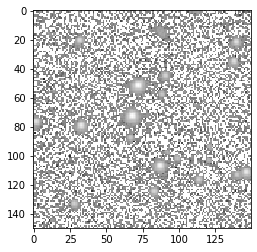

In [221]:
img = sci_crop + streak
plt.imshow(-(-np.log(img / np.max(img))), cmap='gray')

In [28]:
bkg.back()

array([[306.3266 , 306.32117, 306.3155 , ..., 306.7605 , 306.78497,
        306.80954],
       [306.32324, 306.31793, 306.31238, ..., 306.7623 , 306.78662,
        306.81104],
       [306.3197 , 306.3145 , 306.30908, ..., 306.7641 , 306.78827,
        306.81253],
       ...,
       [306.50745, 306.50848, 306.50946, ..., 307.06958, 307.0805 ,
        307.0915 ],
       [306.52072, 306.52164, 306.52246, ..., 307.0724 , 307.08344,
        307.09445],
       [306.53406, 306.53485, 306.53555, ..., 307.07523, 307.0863 ,
        307.09747]], dtype=float32)

(array([  50.,  425., 1452., 2206., 1569.,  521.,   88.,   20.,    8.,
          61.]),
 array([-2.7991917 , -2.014183  , -1.2291744 , -0.44416565,  0.34084305,
         1.1258518 ,  1.9108604 ,  2.6958692 ,  3.4808779 ,  4.2658863 ,
         5.050895  ], dtype=float32),
 <a list of 10 Patch objects>)

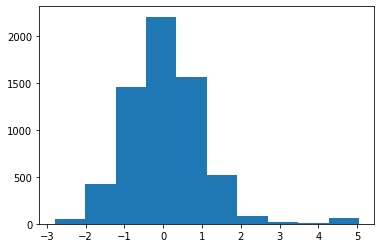

In [243]:
plt.hist(normalize(sci_crop).flatten())

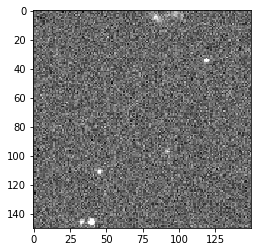

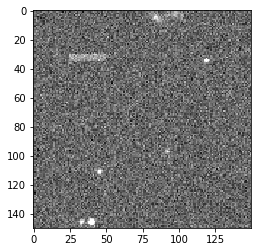

In [865]:
image = np.copy(sci_crop) - sep.Background(sci_crop).back()
# image = np.abs(np.random.randn(100, 100))
# image[np.abs(image) > np.std(image)] = np.std(image)
plt.imshow(normalize(image), cmap="gray")
plt.figure()
image[30:35, 25:50] += np.percentile(np.abs(image[30:35, 25:50]), 68)  * 2
plt.imshow(normalize(image), cmap="gray") 

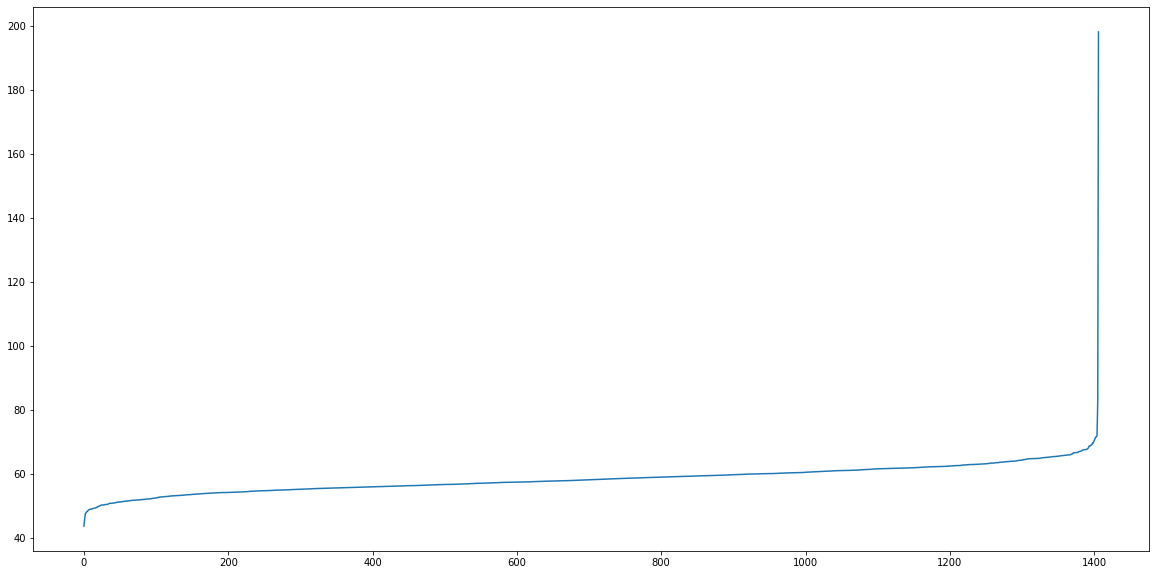

In [888]:
plt.figure(figsize=(20, 10))
plt.plot(np.arange(len(sci_crop.flatten())//16 + 1), np.sort(sci_crop.flatten()[::16]))

In [876]:
np.arange(len(sci_crop.flatten())//8 + 1)

array([   0,    1,    2, ..., 2810, 2811, 2812])

In [880]:
np.sort(sci_crop.flatten()[::16])

array([ 43.69757 ,  45.84712 ,  47.65887 , ...,  72.023186,  82.76744 ,
       198.25479 ], dtype=float32)